## `-` Import Library

In [41]:
# etc
import os, sys, zipfile
import glob
import csv
import cv2
import tqdm
from typing import Tuple, List, Dict
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
# torch library
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
# torchvision library
import torchvision
from torchvision import transforms, models
import torch.optim as optim

## `-` Dataset

In [8]:
# 데이터 전처리
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        #transforms.RandomChoice([
        #    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
        #    transforms.RandomResizedCrop(224),
        #    transforms.RandomAffine(
        #        degrees=15, translate=(0.2, 0.2),
        #        scale = (0.8, 1.2), shear=15, resample=Image.BILINEAR)
        #]),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

# 배치 사이즈와 train:validation 비율 정의
batch_size = 256
val_size = 0.2

# torchvision에서 제공하는 CIFAR10 학습 데이터셋 다운로드
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=train_transform)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download = True, transform=val_transform)

# train 데이터에서 일정 비율 validation data 분리
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(val_size * num_train))
train_idx, val_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

# 데이터로더 정의
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
sampler=train_sampler, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,



                                          sampler=val_sampler, num_workers=2)

# torchvision에서 제공하는 CIFAR10 테스트 데이터셋 다운로드
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=val_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                           shuffle=False, num_workers=2)

# 클래스 정의
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [9]:
# 데이터셋 확인
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

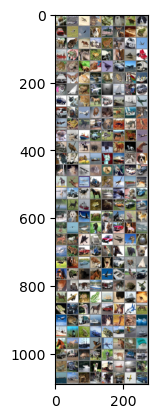

cat   plane plane cat   frog  dog   deer  dog   car   bird  plane dog   ship  deer  frog  frog  horse cat   horse truck frog  horse car   plane ship  frog  horse frog  bird  horse plane truck frog  frog  deer  dog   plane car   plane truck car   dog   frog  deer  cat   frog  bird  ship  dog   ship  frog  plane plane ship  bird  car   car   cat   cat   horse truck ship  ship  plane car   truck plane dog   cat   deer  ship  dog   plane frog  horse cat   dog   bird  plane bird  dog   ship  ship  truck bird  horse horse plane truck bird  horse deer  deer  deer  horse horse dog   ship  ship  ship  cat   truck deer  dog   deer  dog   plane cat   cat   bird  car   car   horse deer  plane truck bird  plane ship  deer  ship  truck dog   horse ship  deer  cat   truck deer  dog   ship  frog  dog   car   car   plane deer  dog   plane horse dog   truck bird  dog   deer  bird  bird  bird  dog   car   dog   plane deer  horse plane truck car   plane bird  frog  plane frog  truck truck bird  bird  cat 

In [12]:
# 이미지 데이터 시각화
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습 이미지 얻기
dataiter = iter(train_loader)
images, labels = next(dataiter)
# 이미지 출력
imshow(torchvision.utils.make_grid(images))
# 라벨 프린트
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [13]:
# 테스트를 위한 Custom Dataset 다운로드
!wget https://drive.google.com/uc?id=1GTES_wxB8b-jsZIqHgNyV9pEgpMLtfzc

--2024-02-05 04:58:20--  https://drive.google.com/uc?id=1GTES_wxB8b-jsZIqHgNyV9pEgpMLtfzc
Resolving drive.google.com (drive.google.com)... 172.217.161.206, 2404:6800:400a:80b::200e
Connecting to drive.google.com (drive.google.com)|172.217.161.206|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1GTES_wxB8b-jsZIqHgNyV9pEgpMLtfzc [following]
--2024-02-05 04:58:21--  https://drive.usercontent.google.com/download?id=1GTES_wxB8b-jsZIqHgNyV9pEgpMLtfzc
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.207.97, 2404:6800:400a:805::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.207.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77122 (75K) [application/octet-stream]
Saving to: ‘uc?id=1GTES_wxB8b-jsZIqHgNyV9pEgpMLtfzc.1’

uc?id=1GTES_wxB8b-j 100%[===================>]  75.31K  --.-KB/s    in 0.1s    

2024-02-05 04:

In [17]:
# 파일 압축 해제
with zipfile.ZipFile("03_classification_custom_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("03_classification_custom_dataset")

In [27]:
for folder in os.listdir('03_classification_custom_dataset/custom_dataset'):
    print(folder)

plane
dog
.DS_Store
cat
bird
car


In [63]:
# 커스텀 데이터셋 클래스
class CUSTOMDataset(Dataset):
    def __init__(self, mode: str = 'test', transforms: transforms = None):
        self.mode = mode
        self.transforms = transforms
        self.images = []
        self.labels = []

        for folder in os.listdir('03_classification_custom_dataset/custom_dataset'):
            files = os.path.join('03_classification_custom_dataset/custom_dataset',folder)
            if folder == '.DS_Store':
                continue
            files_path = os.listdir(files)
            for file in files_path:
                self.images.append(os.path.join(files,file))
                self.labels.append(classes.index(folder))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index: int) -> Tuple[Tensor]:
        image = Image.open(self.images[index]).convert('RGB')
        
        if self.transforms is not None:
            image = self.transforms(image)
            
        image = np.array(image)
        label = self.labels[index]
        return image, label
                
            


In [64]:
# 커스텀 데이터셋 & 로더
custom_dataset = CUSTOMDataset('test', transforms = val_transform)
custom_loader = DataLoader(
    custom_dataset, batch_size=16, shuffle=False, num_workers=2
)

## `-` 모델 불러오기

In [34]:
# 디바이스 체그 & 할당
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [35]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
model = model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


## `-` 로스 함수와 옵티마이저 정의

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## `-` 학습, 검증, 테스트 메소드 정의

In [37]:
def train(epoch):
    train_loss = 0.0
    model.train()
    for i, data in enumerate(tqdm.tqdm(train_loader), 0):
        # 입력 데이터 가져오기 data: [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # parameter gradients를 제로화
        optimizer.zero_grad()

        # 입력 이미지에 대한 출력 생성
        outputs = model(inputs)

        # 손실함수 계산 및 업데이트
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    return train_loss

In [38]:
def val():
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        # 모델 평가 모드 설정
        model.eval()
        for i, data in enumerate(tqdm.tqdm(val_loader), 0):
            # 입력 데이터 가져오기 data: [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # 입력 이미지에 대한 출력 생성
            outputs = model(inputs)

            # 손실함수 계산
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 예측 라벨
            _, predicted = torch.max(outputs, 1)

            # accuracy 계산
            val_accuracy += (predicted == labels).sum().item()

    return val_loss, val_accuracy

In [66]:
def test(test_loader):
    correct = 0
    total = 0
    correct_class = {classname:0 for classname in classes}
    total_class = {classname: 0 for classname in classes}
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # 입력 이미지에 대한 출력 생성
            outputs = model(inputs)

            # 예측 라벨
            _, predicted = torch.max(outputs.data, 1)

            # 전체 정확도 계산
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 클래스 별 정확도 계산
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_class[classes[label]] += 1
                total_class[classes[label]] += 1

    # 전체 정확도 출력
    print(f'Accuracy of the network on the 10000 test images: {100*correct//total}%')
    # 클래스 별 정확도 출력
    for classname, correct_count in correct_class.items():
        if total_class[classname] == 0:
            continue
        accuracy = 100*float(correct_count) / total_class[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f}%')

## `-` 학습

In [44]:
# 학습 epoch 설정
train_epochs = 20
best_acc = 0.0

# 모델 저장 경로 정의
model_path = './cifar_resnet.pth'
for epoch in range(train_epochs):
    # 학습 메소드 실행
    train_loss = train(epoch)
    print(f'[{epoch+1}] loss: {train_loss / len(train_loader):.3f}')
    # 검증 메소드 실행
    val_loss, val_acc = val()
    valid_acc = val_acc / (len(val_loader)*batch_size)
    print(f'[{epoch+1}] loss: {val_loss/len(val_loader):.3f} acc:{valid_acc:.3f}')
    # 정확도가 기존 베스트를 갱신할 경우 모델 저장
    if valid_acc >= best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)

print('Done!!')

100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:18<00:00,  8.40it/s]


[1] loss: 0.581


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.78it/s]


[1] loss: 0.673 acc:0.754


100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:16<00:00,  9.41it/s]


[2] loss: 0.452


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.88it/s]


[2] loss: 0.662 acc:0.760


100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.06it/s]


[3] loss: 0.353


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.33it/s]


[3] loss: 0.648 acc:0.773


100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.16it/s]


[4] loss: 0.263


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.92it/s]


[4] loss: 0.693 acc:0.773


100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.40it/s]


[5] loss: 0.204


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.92it/s]


[5] loss: 0.745 acc:0.776


100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.23it/s]


[6] loss: 0.162


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.26it/s]


[6] loss: 0.762 acc:0.769


100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.37it/s]


[7] loss: 0.131


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 16.28it/s]


[7] loss: 0.781 acc:0.776


100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.61it/s]


[8] loss: 0.093


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.54it/s]


[8] loss: 0.875 acc:0.777


100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.49it/s]


[9] loss: 0.080


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.96it/s]


[9] loss: 0.899 acc:0.777


100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.89it/s]


[10] loss: 0.064


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.95it/s]


[10] loss: 0.884 acc:0.781


100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:14<00:00, 10.85it/s]


[11] loss: 0.053


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.73it/s]


[11] loss: 0.950 acc:0.776


100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.81it/s]


[12] loss: 0.047


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.84it/s]


[12] loss: 0.960 acc:0.781


100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.24it/s]


[13] loss: 0.039


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.87it/s]


[13] loss: 0.964 acc:0.781


100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.55it/s]


[14] loss: 0.032


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.24it/s]


[14] loss: 0.955 acc:0.785


100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:14<00:00, 11.16it/s]


[15] loss: 0.026


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.24it/s]


[15] loss: 1.009 acc:0.780


100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:16<00:00,  9.61it/s]


[16] loss: 0.028


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.80it/s]


[16] loss: 1.056 acc:0.782


100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:17<00:00,  8.87it/s]


[17] loss: 0.028


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.50it/s]


[17] loss: 0.996 acc:0.786


100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.11it/s]


[18] loss: 0.026


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.18it/s]


[18] loss: 1.004 acc:0.788


100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.27it/s]


[19] loss: 0.023


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.19it/s]


[19] loss: 1.029 acc:0.785


100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [00:16<00:00,  9.69it/s]


[20] loss: 0.019


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.73it/s]

[20] loss: 1.042 acc:0.785
Done!!


## `-` 모델 성능 평가

#### 커스텀 데이터셋 테스트

In [67]:
model_path = 'cifar_resnet.pth'
# 모델 가중치 업로드
model.load_state_dict(torch.load(model_path))
# 테스트
test(custom_loader)

Accuracy of the network on the 10000 test images: 68%
Accuracy for class: plane is 100.0%
Accuracy for class: car   is 60.0%
Accuracy for class: bird  is 40.0%
Accuracy for class: cat   is 80.0%
Accuracy for class: dog   is 60.0%


#### 테스트 데이터셋 테스트

In [68]:
model_path = 'cifar_resnet.pth'
# 모델 가중치 업로드
model.load_state_dict(torch.load(model_path))
test(test_loader)

Accuracy of the network on the 10000 test images: 80%
Accuracy for class: plane is 85.0%
Accuracy for class: car   is 88.0%
Accuracy for class: bird  is 75.9%
Accuracy for class: cat   is 62.5%
Accuracy for class: deer  is 77.1%
Accuracy for class: dog   is 71.7%
Accuracy for class: frog  is 85.6%
Accuracy for class: horse is 84.0%
Accuracy for class: ship  is 84.6%
Accuracy for class: truck is 85.7%
